In [28]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import PCA
import xgboost as xgb
import seaborn as sns
from sklearn.metrics import recall_score


In [5]:
#"C:\Users\pc\DIA_testset_RDKit_descriptors.csv"
#"C:\Users\pc\DIA_trainingset_RDKit_descriptors.csv"
X = pd.read_csv("DIA_trainingset_RDKit_descriptors.csv")
y = pd.read_csv("DIA_testset_RDKit_descriptors.csv")

In [6]:
X.shape

(477, 198)

In [7]:
y.shape

(120, 198)

In [8]:
X.columns

Index(['Label', 'SMILES', 'BalabanJ', 'BertzCT', 'Chi0', 'Chi0n', 'Chi0v',
       'Chi1', 'Chi1n', 'Chi1v',
       ...
       'fr_sulfide', 'fr_sulfonamd', 'fr_sulfone', 'fr_term_acetylene',
       'fr_tetrazole', 'fr_thiazole', 'fr_thiocyan', 'fr_thiophene',
       'fr_unbrch_alkane', 'fr_urea'],
      dtype='object', length=198)

In [9]:
#Data came with training and testing data
#I want to concatenate the two datasets and re-split myself
#So I can control the test size

df = pd.concat([X, y])
df.shape

(597, 198)

In [10]:
df.shape

(597, 198)

In [11]:
#Check target variable for null and na
print(df["Label"].isna().sum())
print(df["Label"].isnull().sum())

0
0


In [12]:
X = df.drop(["Label", "SMILES"], axis = 1)
y = df["Label"]

# z is df without smiles
z = df.drop(["SMILES"], axis = 1)

In [13]:
# Standardization; subtract mean and divide by standard deviation
X_mean = np.mean(X, axis=0)
X_std = np.std(X, axis=0)
X_scaled = (X - X_mean) / X_std

In [14]:
df["Label"].value_counts()

Label
0    449
1    148
Name: count, dtype: int64

In [15]:
comparison = pd.DataFrame({
    'Mean': X.mean(),
    'Median': X.median(),
    'Difference': X.mean() - X.median(),
    'Relative Diff %': abs(((X.mean() - X.median())/X.mean())*100)
})
indices = comparison[comparison['Relative Diff %'] < 5].index
print(f"The features with near normal distributions are {indices}")
comparison

The features with near normal distributions are Index(['BertzCT', 'Chi0', 'Chi0n', 'Chi0v', 'Chi1', 'Chi1n', 'Chi1v', 'Chi2n',
       'Chi2v', 'ExactMolWt', 'FractionCSP3', 'HeavyAtomCount',
       'HeavyAtomMolWt', 'Kappa1', 'LabuteASA', 'MaxAbsPartialCharge',
       'MaxPartialCharge', 'MinAbsPartialCharge', 'MinPartialCharge', 'MolMR',
       'MolWt', 'NumAromaticCarbocycles', 'NumHDonors', 'NumValenceElectrons',
       'PEOE_VSA6', 'PEOE_VSA7', 'fr_C_O_noCOO', 'fr_benzene'],
      dtype='object')


,Mean,Median,Difference,Relative Diff %
BalabanJ,2.143109,1.959,0.184109,8.590738
BertzCT,752.164998,715.966,36.198998,4.812641
Chi0,18.442590,17.897,0.545590,2.958313
Chi0n,14.631025,14.507,0.124025,0.847686
Chi0v,15.132288,14.860,0.272288,1.799385
...,...,...,...,...
fr_thiazole,0.026801,0.000,0.026801,100.000000
fr_thiocyan,0.000000,0.000,0.000000,NaN
fr_thiophene,0.028476,0.000,0.028476,100.000000
fr_unbrch_alkane,0.333333,0.000,0.333333,100.000000


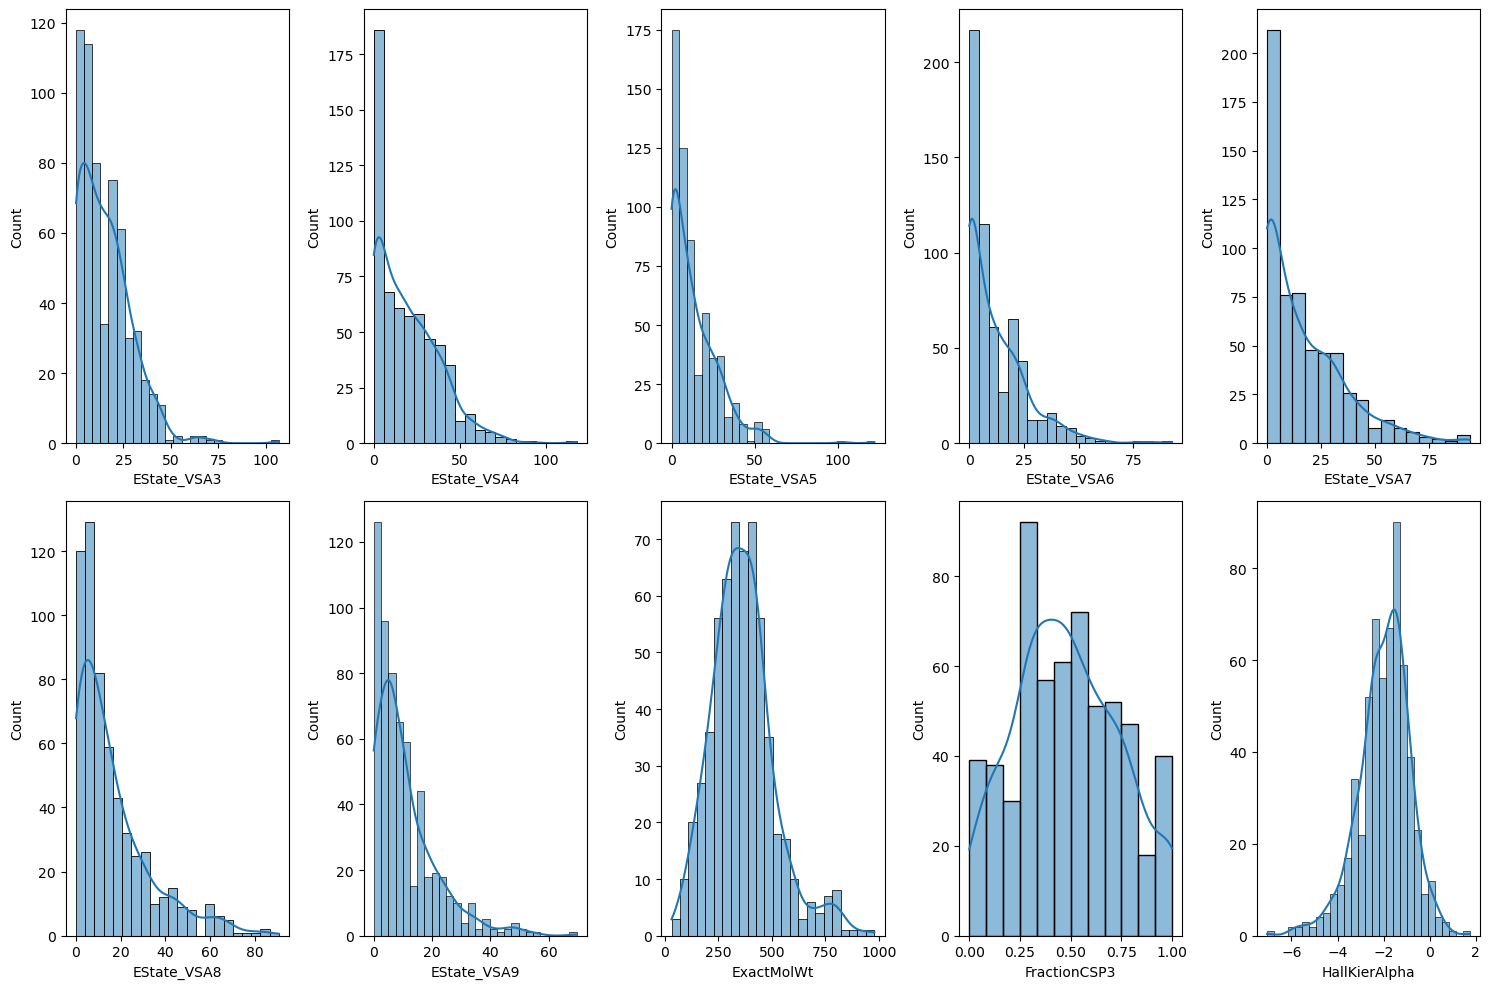

In [197]:
cols = X.columns[18:28]
fig,ax=plt.subplots(2,5,figsize=(15,10))
ax=ax.flatten()
i=0
for col in cols:
    sns.histplot(data=X,x=col,kde=True,ax=ax[i])
    i+=1
plt.tight_layout()
plt.savefig('01_REAL_001_ML_Final_cols18 to 28.png')
plt.show()


In [17]:
X_scaled.isna().sum()
X_scaled.columns.get_loc('fr_thiocyan')

192

In [18]:
# Check for columns with NaN values
columns_with_nan = X_scaled.columns[X_scaled.isna().any()].tolist()

print(columns_with_nan)
print("Number of columns with NA", len(columns_with_nan))

['NumRadicalElectrons', 'SMR_VSA8', 'SlogP_VSA9', 'VSA_EState1', 'VSA_EState2', 'VSA_EState3', 'VSA_EState4', 'VSA_EState5', 'VSA_EState6', 'VSA_EState7', 'fr_azide', 'fr_barbitur', 'fr_diazo', 'fr_isocyan', 'fr_isothiocyan', 'fr_prisulfonamd', 'fr_thiocyan']
Number of columns with NA 17


In [19]:
#get rid of columns with na
X_scaled = X_scaled.drop(['NumRadicalElectrons', 
                          'SMR_VSA8', 
                          'SlogP_VSA9', 
                          'VSA_EState1', 
                          'VSA_EState2', 
                          'VSA_EState3', 
                          'VSA_EState4', 
                          'VSA_EState5', 
                          'VSA_EState6', 
                          'VSA_EState7', 
                          'fr_azide', 
                          'fr_barbitur', 
                          'fr_diazo', 
                          'fr_isocyan', 
                          'fr_isothiocyan', 
                          'fr_prisulfonamd', 
                          'fr_thiocyan'], axis = 1)

In [20]:
X_scaled.shape

(597, 179)

# Principal Component Analysis

In [21]:
# Apply PCA
pca = PCA(n_components=50)  # Reduce to 2 dimensions
X_pca = pca.fit_transform(X_scaled)

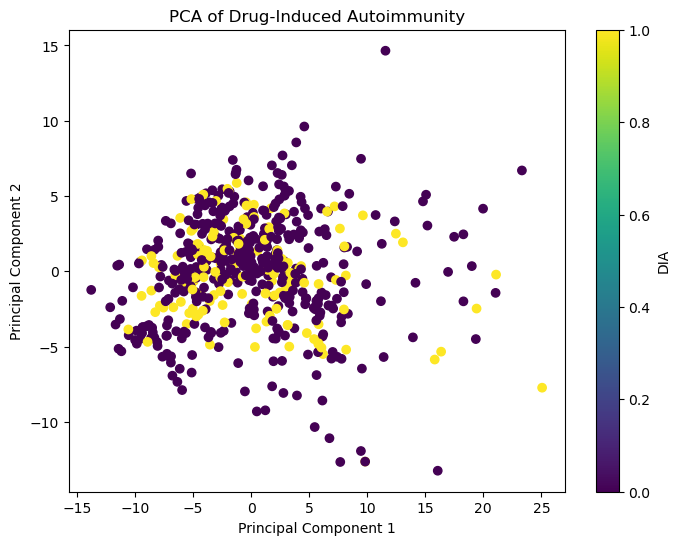

Explained variance ratio: [0.19856071 0.07021876 0.06755244 0.03550374 0.03023333 0.02994975
 0.02876525 0.02529351 0.02303224 0.0200961  0.01958185 0.0166122
 0.01609867 0.0159512  0.01496681 0.01419504 0.01315476 0.0122123
 0.01101888 0.01090469 0.01021981 0.00997211 0.00930267 0.00886792
 0.00845773 0.00815423 0.0080751  0.0079804  0.00778878 0.00760747
 0.00713481 0.00693071 0.00681848 0.00671909 0.00653327 0.00639679
 0.00630691 0.00609533 0.00603068 0.00585215 0.00560024 0.00557268
 0.00550954 0.00538752 0.00530147 0.00511277 0.00508853 0.00497349
 0.00482546 0.00469939]


In [22]:
# Explained variance ratio
explained_variance = pca.explained_variance_ratio_

# Plot the results
plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('PCA of Drug-Induced Autoimmunity')
plt.colorbar(label='DIA')
plt.show()

print("Explained variance ratio:", explained_variance)

In [23]:
# Get the loadings
loadings = pca.components_.T

feature_names = X_scaled.columns
first_pc_loadings = pca.components_[0]
first_pc_abs = np.abs(first_pc_loadings)


In [24]:
indices = np.argsort(first_pc_abs)[::-1]
sorted_load = first_pc_abs[indices]
sorted_feat = feature_names[indices]

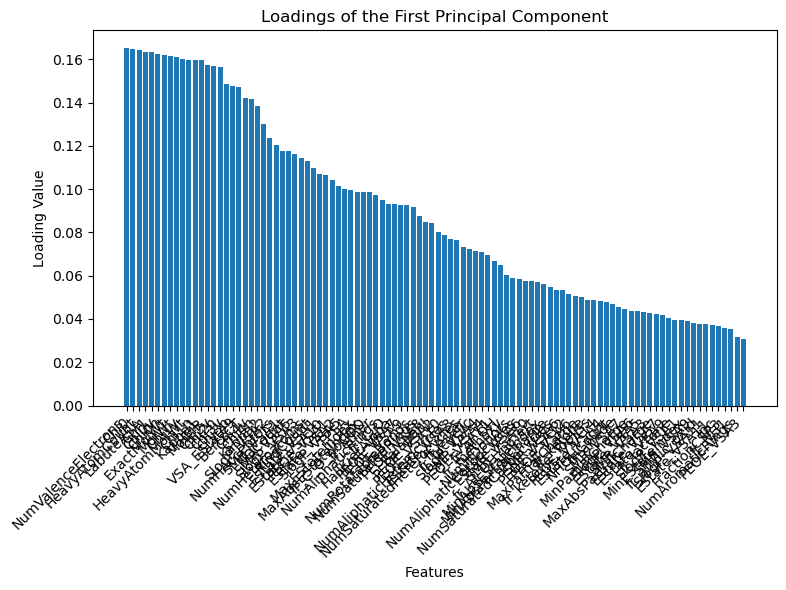

In [25]:

a = 100
# Visualize the loadings
plt.figure(figsize=(8, 6))
plt.bar(sorted_feat[:a], sorted_load[:a])
plt.xlabel('Features')
plt.ylabel('Loading Value')
plt.title('Loadings of the First Principal Component')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

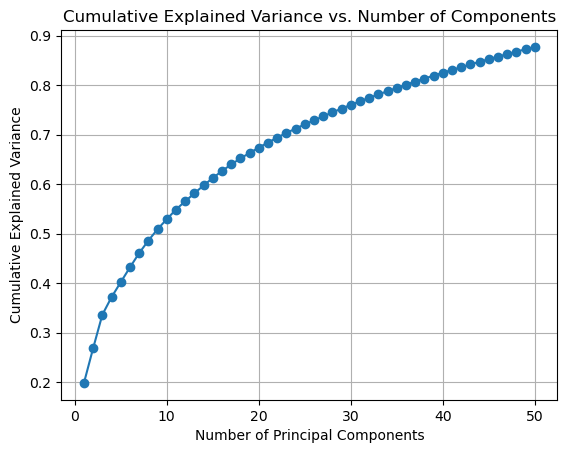

In [26]:
# Calculate cumulative explained variance
cumulative_variance = np.cumsum(pca.explained_variance_ratio_)

# Plot cumulative explained variance
plt.plot(range(1, len(cumulative_variance) + 1), cumulative_variance, marker='o')
plt.xlabel('Number of Principal Components')
plt.ylabel('Cumulative Explained Variance')
plt.title('Cumulative Explained Variance vs. Number of Components')
plt.grid(True)
plt.savefig('ML Final Project Cumulative Explained Variance2.png')
plt.show()


In [29]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)
# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

# Train the LDA classifier
lda.fit(X_train_scaled, y_train_scaled)

# Predict on the test data
y_pred = lda.predict(X_test_scaled)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_scaled, y_pred)
recall = recall_score(y_test_scaled, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")
#Transform the data
X_train_transformed = lda.transform(X_train_scaled)
X_test_transformed = lda.transform(X_test_scaled)

print("Original feature shape:", X_train_scaled.shape)
print("Transformed feature shape:", X_train_transformed.shape)
print("confusion matrix")
print(confusion_matrix(y_test_scaled, y_pred))

Accuracy: 0.7444444444444445
Recall Score: 0.27906976744186046
Original feature shape: (417, 179)
Transformed feature shape: (417, 1)
confusion matrix
[[122  15]
 [ 31  12]]


# Try LDA unscaled



In [30]:
# Create an LDA classifier
lda = LinearDiscriminantAnalysis()

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42)
# Train the LDA classifier
lda.fit(X_train, y_train)

# Predict on the test data
y_pred = lda.predict(X_test)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred) 
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")
#Transform the data
X_train_transformed = lda.transform(X_train)
X_test_transformed = lda.transform(X_test)

print("Original feature shape:", X_train.shape)
print("Transformed feature shape:", X_train_transformed.shape)
print("confusion matrix")
print(confusion_matrix(y_test_scaled, y_pred))

Accuracy: 0.7222222222222222
Recall Score: 0.4883720930232558
Original feature shape: (417, 196)
Transformed feature shape: (417, 1)
confusion matrix
[[109  28]
 [ 22  21]]


Performed slightly worse

# Now try Quadratic Discriminant Analysis

In [31]:
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train_scaled, y_train_scaled)

\\?\C:\Users\pc\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 0 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(
\\?\C:\Users\pc\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\discriminant_analysis.py:1024: LinAlgWarning: The covariance matrix of class 1 is not full rank. Increasing the value of parameter `reg_param` might help reducing the collinearity.
  warnings.warn(


QuadraticDiscriminantAnalysis()

In [32]:


# Predict on the test set
y_pred = qda.predict(X_test_scaled)

# Evaluate the model
accuracy = accuracy_score(y_test_scaled, y_pred)
print(f"Accuracy: {accuracy}")

print("Confusion Matrix:")
print(confusion_matrix(y_test_scaled, y_pred))

print("Classification Report:")
print(classification_report(y_test_scaled, y_pred))

Accuracy: 0.7388888888888889
Confusion Matrix:
[[133   4]
 [ 43   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.76      0.97      0.85       137
           1       0.00      0.00      0.00        43

    accuracy                           0.74       180
   macro avg       0.38      0.49      0.42       180
weighted avg       0.58      0.74      0.65       180



In [33]:
from sklearn.svm import SVC
from sklearn import svm
# Create an SVM classifier
clf = SVC(kernel='linear', C=1.0, random_state=42)

# Train the classifier
clf.fit(X_train_scaled, y_train)

# Predict on the test set
y_pred = clf.predict(X_test_scaled)

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")
print(f"Recall: {recall}")

Accuracy: 0.7277777777777777
Recall: 0.46511627906976744


# Baseline

In [34]:
# Define different kernels
kernels = ['linear', 'poly', 'rbf', 'sigmoid']

# Train and evaluate SVM models with different kernels
for kernel in kernels:
    # Create SVM classifier with specified kernel
    clf = svm.SVC(kernel=kernel)
    
    # Train the classifier
    clf.fit(X_train_scaled, y_train)

    y_pred = clf.predict(X_test_scaled)
    # Evaluate the classifier
    accuracy = clf.score(X_test_scaled, y_test)
    print(kernel)
    print(f"Accuracy with {kernel} kernel: {accuracy:.2f}")
    print(confusion_matrix(y_test, y_pred))
    print(recall_score(y_test, y_pred))
    print("\n")
    


linear
Accuracy with linear kernel: 0.73
[[111  26]
 [ 23  20]]
0.46511627906976744


poly
Accuracy with poly kernel: 0.76
[[133   4]
 [ 40   3]]
0.06976744186046512


rbf
Accuracy with rbf kernel: 0.80
[[134   3]
 [ 33  10]]
0.23255813953488372


sigmoid
Accuracy with sigmoid kernel: 0.77
[[134   3]
 [ 38   5]]
0.11627906976744186




In [35]:
  # Calculate the correlation matrix
corr_matrix = z.corr()

  # Extract correlations with the target variable
target_corr = corr_matrix['Label'].sort_values(ascending=False)

  # Remove the target variable's self-correlation (which is always 1)
target_corr = target_corr[target_corr.index != 'Label']

In [36]:
target_corr

fr_aniline         0.215703
fr_priamide        0.170943
SlogP_VSA10        0.151926
fr_ArN             0.150547
fr_amide           0.145187
                     ...   
fr_diazo                NaN
fr_isocyan              NaN
fr_isothiocyan          NaN
fr_prisulfonamd         NaN
fr_thiocyan             NaN
Name: Label, Length: 196, dtype: float64

# Random Forest with PCA

In [37]:
 X_train1, X_test1, y_train1, y_test1 = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

In [38]:
pca = PCA(n_components=50) # Choose the number of components
X_train_rfpca = pca.fit_transform(X_train1)
X_test_rfpca = pca.transform(X_test1)

In [39]:
from sklearn.ensemble import RandomForestClassifier

In [40]:
rf_pca_clf = RandomForestClassifier(n_estimators = 100, random_state = 42)
rf_pca_clf.fit(X_train_rfpca, y_train1)

RandomForestClassifier(random_state=42)

In [41]:
y_pred_rfpca = rf_pca_clf.predict(X_test_rfpca)

In [42]:
print(confusion_matrix(y_test1, y_pred_rfpca))
print(accuracy_score(y_test1, y_pred_rfpca))
print(recall_score(y_test1, y_pred_rfpca))

[[83  5]
 [17 15]]
0.8166666666666667
0.46875


# Feature Scaling

In [43]:

#find the best parameters

from sklearn.model_selection import RandomizedSearchCV
param_grid = {
    'n_estimators': [100, 500, 1000],
    'max_depth': [5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'bootstrap': [True, False]
}

# Create a Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# Use RandomizedSearchCV for hyperparameter tuning
rf_random = RandomizedSearchCV(estimator=rf, param_distributions=param_grid, n_iter=10, cv=3, random_state=42, n_jobs=-1)

# Fit the random search model
rf_random.fit(X_train, y_train)

# Print the best parameters found
print("Best parameters:", rf_random.best_params_)

# Evaluate the model with the best parameters
best_rf = rf_random.best_estimator_
accuracy = best_rf.score(X_test, y_test)
print("Accuracy on the test set:", accuracy)

Best parameters: {'n_estimators': 100, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_depth': 15, 'bootstrap': False}
Accuracy on the test set: 0.8222222222222222


In [44]:
rf_baseline = RandomForestClassifier(
    n_estimators=100,
    min_samples_split=2,
    min_samples_leaf=2,
    max_depth=15,
    bootstrap=False,
    random_state=42 
)
rf_baseline.fit(X_train, y_train)
y_pred = rf_baseline.predict(X_test)
print("Confusion matrix\n", confusion_matrix(y_test, y_pred))
print("Accuracy", accuracy_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

Confusion matrix
 [[132   5]
 [ 27  16]]
Accuracy 0.8222222222222222
Recall 0.37209302325581395


In [47]:

baseline_importances = rf_baseline.feature_importances_
dfi = pd.DataFrame({'Feature Name': X.columns, 'Importance Value': baseline_importances})
dfi_sort = dfi.sort_values(by = 'Importance Value')
dfi_sort.shape

(196, 2)

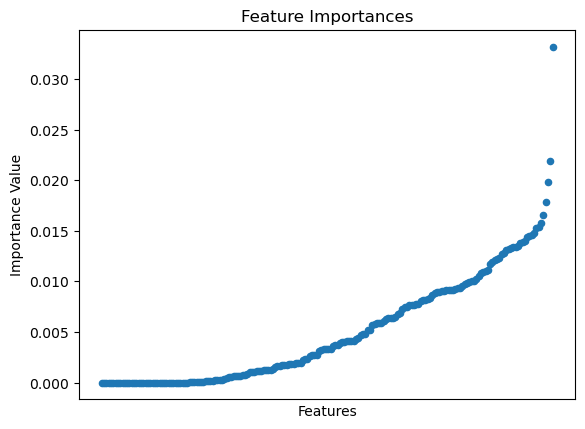

In [48]:
# Create the scatter plot
ax = dfi_sort.plot.scatter(x='Feature Name', y='Importance Value', title='Feature Importances')

# Optional: Customize the plot further
ax.set_xlabel('Features')
ax.set_ylabel('Importance Value')
ax.set_xticks([])

# Display the plot
plt.show()

In [49]:
dfi_sort = dfi_sort[dfi_sort['Importance Value'] > 0.009]

In [50]:
dfi_sort.shape

(49, 2)

In [51]:
#dfi_sort

In [52]:
Xi = X[dfi_sort['Feature Name']].copy()

In [53]:
Xi

,PEOE_VSA7,EState_VSA10,Chi3v,ExactMolWt,SlogP_VSA5,Chi0n,Chi1,NumValenceElectrons,NHOHCount,MolLogP,...,EState_VSA4,SlogP_VSA2,PEOE_VSA8,MinAbsEStateIndex,MinAbsPartialCharge,fr_aniline,PEOE_VSA6,MinEStateIndex,SlogP_VSA10,PEOE_VSA2
0,18.199,9.185,4.719,422.162,5.563,16.781,14.901,158,4,2.443,...,4.900,44.983,18.808,0.018,0.413,3,18.199,-0.668,26.508,4.900
1,24.443,10.002,3.735,236.062,17.843,8.752,7.592,84,3,2.732,...,14.963,16.302,9.577,0.421,0.339,0,18.199,-0.843,4.795,5.207
2,0.000,9.901,0.603,117.079,0.000,5.471,3.417,48,0,-1.557,...,0.000,38.140,0.000,0.069,0.118,0,0.000,-1.002,0.000,0.000
3,43.686,19.398,4.998,411.185,38.425,16.995,14.274,158,3,4.628,...,27.724,38.064,34.623,0.073,0.305,0,36.408,-1.130,4.390,4.795
4,31.189,17.966,2.171,270.062,12.487,9.746,8.752,100,2,2.999,...,31.189,11.014,5.687,0.090,0.416,1,0.000,-4.456,18.859,4.795
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,26.335,33.874,8.132,516.155,32.377,19.925,16.973,192,2,-1.575,...,4.900,92.168,24.381,0.026,0.325,0,30.332,-1.370,4.795,24.078
116,30.686,4.795,2.350,211.075,11.257,8.689,7.720,78,1,1.617,...,16.821,9.968,23.651,0.123,0.266,0,0.000,-0.349,0.000,9.779
117,67.289,5.107,5.620,315.166,35.769,13.294,10.775,118,1,4.266,...,32.228,29.138,17.464,0.483,0.119,0,25.123,0.483,0.000,4.900
118,33.258,19.703,4.478,418.174,39.176,17.683,14.167,162,1,2.971,...,0.000,43.289,30.637,0.030,0.337,1,12.133,-0.882,5.687,10.114


In [54]:

Xi_train, Xi_test, yi_train, yi_test = train_test_split(Xi, y, test_size = 0.25, random_state = 42)
# XGBoost classifier
model = xgb.XGBClassifier(objective='binary:logistic', n_estimators=100, random_state=42)

# Train the model
model.fit(Xi_train, yi_train)

# Make predictions
yi_pred = model.predict(Xi_test)

# Evaluate the model
accuracy = accuracy_score(yi_test, yi_pred)
recall = recall_score(yi_test, yi_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion matrix:")
print(confusion_matrix(yi_test, yi_pred))

Accuracy: 0.78
Recall: 0.5263157894736842
Confusion matrix:
[[97 15]
 [18 20]]


In [55]:
Xi["NumValenceElectrons_log"] = np.log(Xi["NumValenceElectrons"])

In [56]:
import numpy as np

In [57]:
Xi_log = Xi.copy()
st1, st2, st3, st4, st5 = "fr_aniline", 'EState_VSA6', 'SMR_VSA10', 'SMR_VSA5', 'SMR_VSA1'
st6 = 'MaxEStateIndex'
st7 = 'PEOE_VSA9'
st8 = 'MaxAbsEStateIndex'
st9 = 'Ipc' 
st10 = 'SMR_VSA6'
st11 = 'Kappa3'

# Xi_log[st2] = np.log(Xi_log[st2])
# Xi_log[st3] = np.log(Xi_log[st3])
# Xi_log[st4] = np.log(Xi_log[st4])
# Xi_log[st5] = np.log(Xi_log[st5])
# Xi_log[st6] = np.log(Xi_log[st6])
# Xi_log[st7] = np.log(Xi_log[st7])
# Xi_log[st8] = np.log(Xi_log[st8])
# Xi_log[st9] = np.log(Xi_log[st9])
# Xi_log[st10] = np.log(Xi_log[st10])
# Xi_log[st11] = np.log(Xi_log[st11])

# Xi_log
# fr_aniline              1.973503
# EState_VSA6             1.717221
# SMR_VSA10               1.502199
# SMR_VSA5                1.408489
# SMR_VSA1                1.529620
# MaxEStateIndex         -1.120834
# PEOE_VSA9               1.972929
# MaxAbsEStateIndex      -1.120834
# Ipc                    22.669638
# SMR_VSA6                2.069556
# Kappa3                 17.202058

In [58]:
X_train_log, X_test_log, y_train_log, y_test_log = train_test_split(Xi, y, test_size = 0.3, random_state = 42)

In [59]:

rf_baseline.fit(X_train_log, y_train_log)
y_pred = rf_baseline.predict(X_test_log)
print("Confusion matrix\n", confusion_matrix(y_test, y_pred))
print("Accuracy", accuracy_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

Confusion matrix
 [[129   8]
 [ 28  15]]
Accuracy 0.8
Recall 0.3488372093023256


In [60]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_norm = pd.DataFrame(scaler.fit_transform(X), columns=X.columns)

In [61]:
X_train_norm, X_test_norm, y_train_norm, y_test_norm = train_test_split(X_norm, y, test_size = 0.3, random_state = 42)

In [62]:
rf_baseline.fit(X_train_norm, y_train_norm)
y_pred = rf_baseline.predict(X_test_norm)
print("Confusion matrix\n", confusion_matrix(y_test, y_pred))
print("Accuracy", accuracy_score(y_test, y_pred))
print("Recall", recall_score(y_test, y_pred))

Confusion matrix
 [[132   5]
 [ 27  16]]
Accuracy 0.8222222222222222
Recall 0.37209302325581395


In [63]:
X_train_scaled, X_test_scaled, y_train_scaled, y_test_scaled = train_test_split(X_scaled, y, test_size = 0.3, random_state = 42)

In [64]:
# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Evaluate the model
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion matrix:")
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.8055555555555556
Recall: 0.4883720930232558
Confusion matrix:
[[124  13]
 [ 22  21]]


In [65]:
from sklearn.linear_model import LogisticRegression

In [69]:
print(X_train_scaled.shape)
print(X_test_scaled.shape)
logreg.fit(X_train_scaled, y_train_scaled)



(417, 179)
(180, 179)


LogisticRegression(max_iter=100000)

In [70]:
logreg = LogisticRegression(max_iter = 100000)
logreg.fit(X_train, y_train)

y_pred = logreg.predict(X_test)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))


accuracy:  0.7611111111111111
recall: 0.0


In [71]:
# y_pred = model.predict(X_test_log)

rf_baseline.fit(X_train_scaled, y_train_scaled)
y_pred = rf_baseline.predict(X_test_scaled)
print("Confusion matrix\n", confusion_matrix(y_test_scaled, y_pred))
print("Accuracy", accuracy_score(y_test_scaled, y_pred))
print("Recall", recall_score(y_test_scaled, y_pred))

Confusion matrix
 [[134   3]
 [ 28  15]]
Accuracy 0.8277777777777777
Recall 0.3488372093023256


In [72]:
lda.fit(X_train_log, y_train_log)

# Predict on the test data
y_pred = lda.predict(X_test_log)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_log, y_pred)
recall = recall_score(y_test_log, y_pred) 
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")

Accuracy: 0.75
Recall Score: 0.4418604651162791


In [73]:
Xi.columns

Index(['PEOE_VSA7', 'EState_VSA10', 'Chi3v', 'ExactMolWt', 'SlogP_VSA5',
       'Chi0n', 'Chi1', 'NumValenceElectrons', 'NHOHCount', 'MolLogP',
       'EState_VSA3', 'Chi2v', 'Kappa3', 'Chi2n', 'Chi4v', 'Chi4n', 'SMR_VSA6',
       'SMR_VSA1', 'FractionCSP3', 'SMR_VSA7', 'PEOE_VSA1', 'BertzCT',
       'SlogP_VSA6', 'Chi0v', 'MaxPartialCharge', 'VSA_EState9',
       'MaxEStateIndex', 'TPSA', 'fr_NH2', 'EState_VSA1', 'MinPartialCharge',
       'MaxAbsEStateIndex', 'SMR_VSA5', 'PEOE_VSA9', 'BalabanJ',
       'MaxAbsPartialCharge', 'SMR_VSA10', 'HallKierAlpha', 'SlogP_VSA1',
       'EState_VSA4', 'SlogP_VSA2', 'PEOE_VSA8', 'MinAbsEStateIndex',
       'MinAbsPartialCharge', 'fr_aniline', 'PEOE_VSA6', 'MinEStateIndex',
       'SlogP_VSA10', 'PEOE_VSA2', 'NumValenceElectrons_log'],
      dtype='object')

In [74]:
from sklearn.preprocessing import PolynomialFeatures


In [75]:
poly = PolynomialFeatures(degree = 2)
X_poly = poly.fit_transform(Xi)

In [76]:
X_train_poly, X_test_poly, y_train_poly, y_test_poly = train_test_split(X_poly, y, test_size = 0.3, random_state = 42)

In [77]:
logreg.fit(X_train_poly, y_train_poly)


\\?\C:\Users\pc\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression(max_iter=100000)

In [78]:
y_pred = logreg.predict(X_test_poly)

print("accuracy: ", accuracy_score(y_test, y_pred))
print("recall:", recall_score(y_test, y_pred))

accuracy:  0.75
recall: 0.6046511627906976


In [79]:
#RF poly
rf_baseline.fit(X_train_poly, y_train_poly)
y_pred = rf_baseline.predict(X_test_poly)
print("Confusion matrix\n", confusion_matrix(y_test_poly, y_pred))
print("Accuracy", accuracy_score(y_test_poly, y_pred))
print("Recall", recall_score(y_test_poly, y_pred))

Confusion matrix
 [[128   9]
 [ 23  20]]
Accuracy 0.8222222222222222
Recall 0.46511627906976744


In [80]:
lda.fit(X_train_poly, y_train_poly)

# Predict on the test data
y_pred = lda.predict(X_test_poly)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_poly, y_pred)
recall = recall_score(y_test_poly, y_pred) 
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")

Accuracy: 0.7
Recall Score: 0.627906976744186


In [81]:
# Train the model
model.fit(X_train_poly, y_train_poly)

# Make predictions
y_pred = model.predict(X_test_poly)

# Evaluate the model
accuracy = accuracy_score(y_test_poly, y_pred)
recall = recall_score(y_test_poly, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion matrix:")
print(confusion_matrix(y_test_poly, y_pred))

Accuracy: 0.8222222222222222
Recall: 0.4883720930232558
Confusion matrix:
[[127  10]
 [ 22  21]]


In [82]:
X_top10 = Xi.iloc[:, :10]

In [83]:
X_top10.shape

(597, 10)

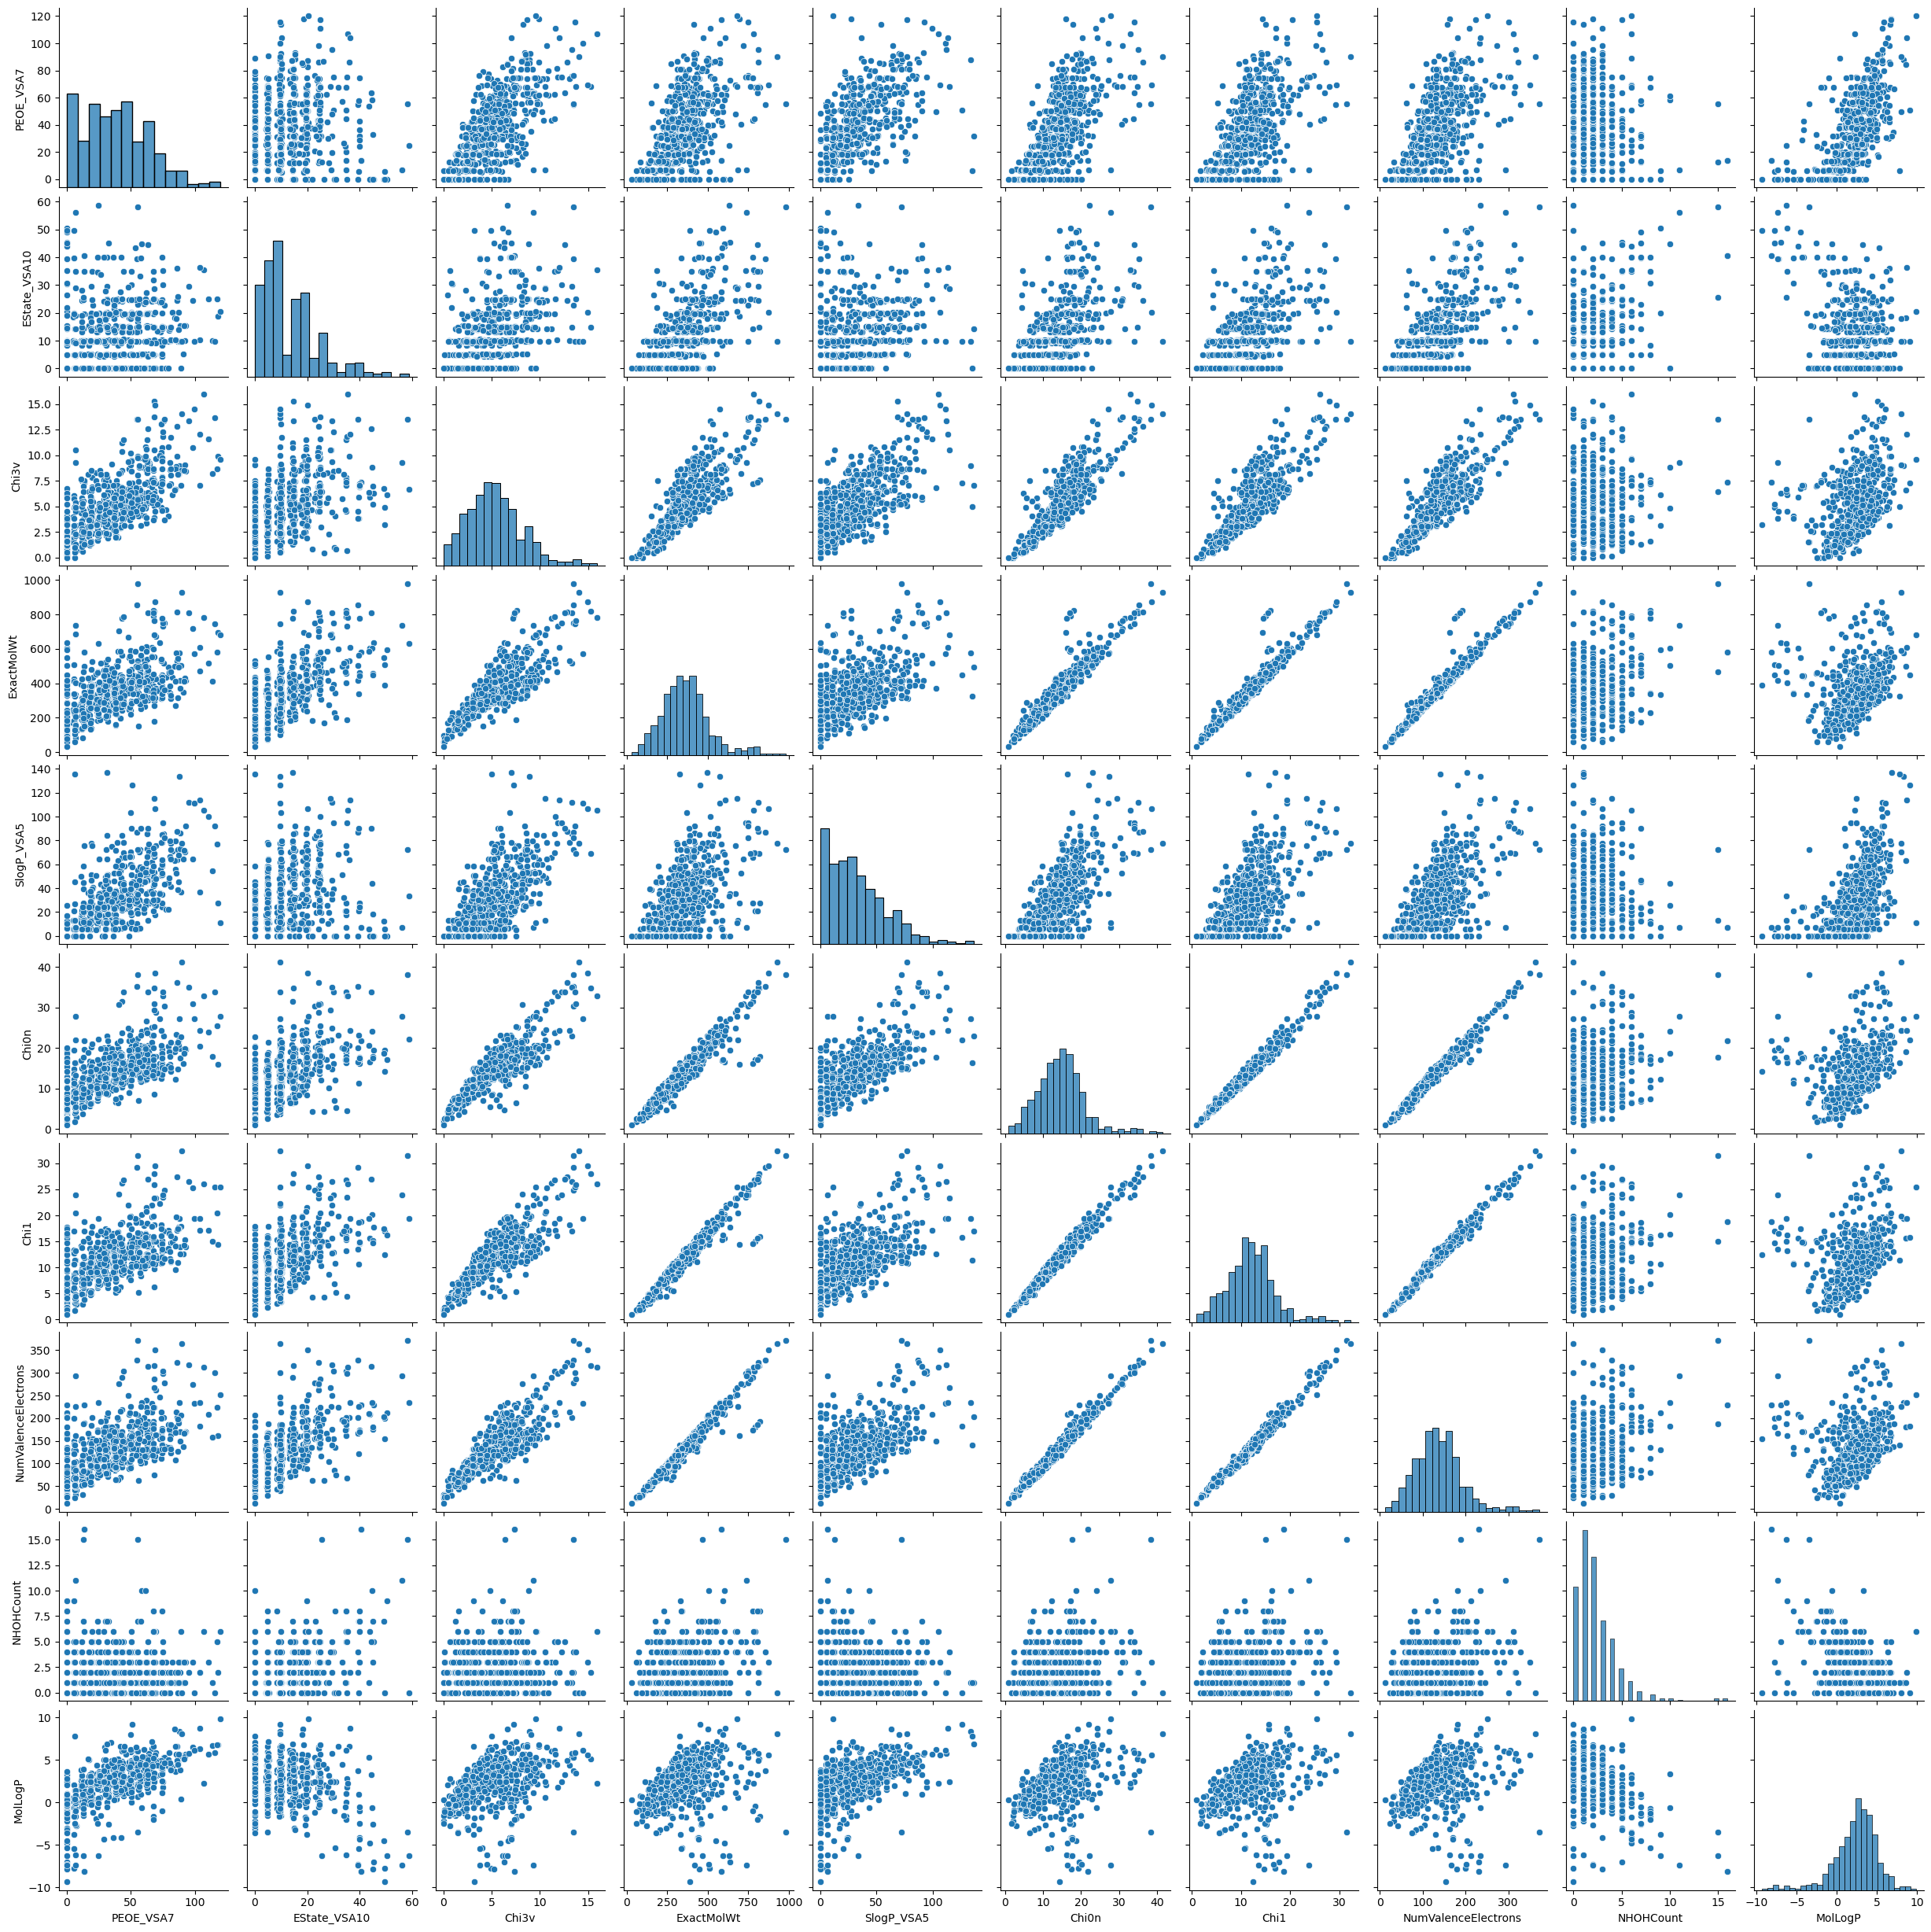

In [84]:
sns.pairplot(X_top10)
plt.show()

In [85]:
X_top10.columns

Index(['PEOE_VSA7', 'EState_VSA10', 'Chi3v', 'ExactMolWt', 'SlogP_VSA5',
       'Chi0n', 'Chi1', 'NumValenceElectrons', 'NHOHCount', 'MolLogP'],
      dtype='object')

In [86]:
Xi['Interaction 1'] = Xi['ExactMolWt']*Xi['Chi3v']

In [87]:
Xi['Interaction 2'] = Xi['Chi0n']*Xi['Chi1']

In [88]:
Xi['Interaction 3'] = Xi['NumValenceElectrons']*Xi['Chi1']

In [89]:
# X_interaction = X_top10[['Interaction 1', 'Interaction 2', 'Interaction 3']]

In [90]:
X_train_int, X_test_int, y_train_int, y_test_int = train_test_split(Xi, y, test_size = 0.3, random_state = 42)

In [91]:
logreg.fit(X_train_int, y_train_int)
y_pred = logreg.predict(X_test_int)

print("accuracy: ", accuracy_score(y_test_int, y_pred))
print("recall:", recall_score(y_test_int, y_pred))

accuracy:  0.7833333333333333
recall: 0.5116279069767442


\\?\C:\Users\pc\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [92]:
#XGBOOST Interaction

# Train the model
model.fit(X_train_int, y_train_int)

# Make predictions
y_pred = model.predict(X_test_int)

# Evaluate the model
accuracy = accuracy_score(y_test_int, y_pred)
recall = recall_score(y_test_int, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion matrix:")
print(confusion_matrix(y_test_int, y_pred))

Accuracy: 0.8055555555555556
Recall: 0.5348837209302325
Confusion matrix:
[[122  15]
 [ 20  23]]


In [93]:
#LDA INTERACTION
lda.fit(X_train_int, y_train_int)

# Predict on the test data
y_pred = lda.predict(X_test_int)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_int, y_pred)
recall = recall_score(y_test_int, y_pred) 
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")

Accuracy: 0.7333333333333333
Recall Score: 0.3953488372093023


In [94]:
#RF INTERACTION

rf_baseline.fit(X_train_int, y_train_int)
y_pred = rf_baseline.predict(X_test_int)
print("Confusion matrix\n", confusion_matrix(y_test_int, y_pred))
print("Accuracy", accuracy_score(y_test_int, y_pred))
print("Recall", recall_score(y_test_int, y_pred))

Confusion matrix
 [[130   7]
 [ 25  18]]
Accuracy 0.8222222222222222
Recall 0.4186046511627907


In [95]:
#Chi combination

Xi['Chi Combination'] = Xi['Chi0n'] * Xi['Chi1'] * Xi['Chi3v']
Xi['Chi Electron Ratio'] = Xi['Chi Combination'] / Xi['ExactMolWt']
Xi['PEOE_VSA7_squared'] = Xi['PEOE_VSA7']**2

In [96]:
Xi = Xi.drop('PEOE_VSA7_squared', axis = 1)

In [97]:
X_train_chi, X_test_chi, y_train_chi, y_test_chi = train_test_split(Xi, y, test_size = 0.3, random_state = 42)

In [98]:
#XGBOOST chi

# Train the model
model.fit(X_train_chi, y_train_chi)

# Make predictions
y_pred = model.predict(X_test_chi)

# Evaluate the model
accuracy = accuracy_score(y_test_chi, y_pred)
recall = recall_score(y_test_chi, y_pred)
print("Accuracy:", accuracy)
print("Recall:", recall)
print("Confusion matrix:")
print(confusion_matrix(y_test_chi, y_pred))

Accuracy: 0.8111111111111111
Recall: 0.5581395348837209
Confusion matrix:
[[122  15]
 [ 19  24]]


In [99]:
logreg.fit(X_train_chi, y_train_chi)
y_pred = logreg.predict(X_test_chi)

print("accuracy: ", accuracy_score(y_test_chi, y_pred))
print("recall:", recall_score(y_test_chi, y_pred))

accuracy:  0.7722222222222223
recall: 0.4883720930232558


\\?\C:\Users\pc\AppData\Roaming\jupyterlab-desktop\jlab_server\Lib\site-packages\sklearn\linear_model\_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of f AND g EVALUATIONS EXCEEDS LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [100]:
lda.fit(X_train_chi, y_train_chi)

# Predict on the test data
y_pred = lda.predict(X_test_chi)

# Calculate the accuracy of the model
accuracy = accuracy_score(y_test_chi, y_pred)
recall = recall_score(y_test_chi, y_pred) 
print(f"Accuracy: {accuracy}")
print(f"Recall Score: {recall}")

Accuracy: 0.7277777777777777
Recall Score: 0.3953488372093023


In [101]:
#RF poly
rf_baseline.fit(X_train_chi, y_train_chi)
y_pred = rf_baseline.predict(X_test_chi)
print("Confusion matrix\n", confusion_matrix(y_test_chi, y_pred))
print("Accuracy", accuracy_score(y_test_chi, y_pred))
print("Recall", recall_score(y_test_chi, y_pred))

Confusion matrix
 [[131   6]
 [ 26  17]]
Accuracy 0.8222222222222222
Recall 0.3953488372093023


In [200]:
import time

In [228]:
import sys

In [232]:
# Apply PCA
pca = PCA(n_components=2)  # Reduce to 2 dimensions
X_pca1 = pca.fit_transform(X_scaled)

X_train_pca, X_test_pca, y_train_pca, y_test_pca = train_test_split(X_pca1, y, test_size = 0.3, random_state = 42)

In [233]:
#RF PCA
print("RANDOM FORESTS")
rf_fitt0 = time.time()
rf_baseline.fit(X_train_pca, y_train_pca)
rf_fitt1 = time.time()

rf_predt0 = time.time()
y_pred = rf_baseline.predict(X_test_pca)
rf_predt1 = time.time()
#print("Confusion matrix\n", confusion_matrix(y_test_pca, y_pred))
print("Accuracy", accuracy_score(y_test_pca, y_pred))
print("Recall", recall_score(y_test_pca, y_pred))

rfms = sys.getsizeof(rf_baseline)


#LOGISTIC REGRESSION PCA
print("\n\n")
print("LOGISTIC REGRESSION")

lr_fitt0 = time.time()
logreg.fit(X_train_pca, y_train_pca)
lr_fitt1 = time.time()

lr_predt0 = time.time()
y_pred = logreg.predict(X_test_pca)
lr_predt1 = time.time()
print("accuracy: ", accuracy_score(y_test_pca, y_pred))
print("recall:", recall_score(y_test_pca, y_pred))


lrms = sys.getsizeof(logreg)
#XGBOOST PCA

# Train the model

xgb_fitt0 = time.time()
model.fit(X_train_pca, y_train_pca)
xgb_fitt1 = time.time()
# Make predictions

xgb_predt0 = time.time()
y_pred = model.predict(X_test_pca)
xgb_predt1 = time.time()
# Evaluate the model
accuracy = accuracy_score(y_test_pca, y_pred)
recall = recall_score(y_test_pca, y_pred)
print("\n\n")
print("XGBOOST")
print("Accuracy:", accuracy)
print("Recall:", recall)

xgbms = sys.getsizeof(model)
#print("Confusion matrix:")
#print(confusion_matrix(y_test_pca, y_pred))

#LINEAR SVM PCA
print('\n\n')
print("SVM PCA")
# Create SVM classifier with specified kernel
clf = svm.SVC(kernel='linear')
    
# Train the classifier
svm_fitt0 = time.time()
clf.fit(X_train_pca, y_train)
svm_fitt1 = time.time()

svm_predt0 = time.time()
y_pred = clf.predict(X_test_pca)
svm_predt1 = time.time()
# Evaluate the classifier
accuracy = clf.score(X_test_pca, y_test_pca)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print("\n")

svmms = sys.getsizeof(clf)
#calculate training times

rf_train = rf_fitt1 - rf_fitt0
lr_train = lr_fitt1 - lr_fitt0
xgb_train = xgb_fitt1 - xgb_fitt0
svm_train = svm_fitt1 - svm_fitt0

# pred times

rf_pt = rf_predt1 - rf_predt0
lr_pt = lr_predt1 - lr_predt0
xgb_pt = xgb_predt1 - xgb_predt0
svm_pt = svm_predt1 - svm_predt0



print("\n\n\n")
print("Training Times")
print("Random Forests:", rf_train)
print("Logistic Regression:", lr_train)
print("XGB:", xgb_train)
print("SVM:", svm_train)

print("\n")
print("Prediction times")
print("Random Forests:", rf_pt)
print("Logistic Regression:", lr_pt)
print("XGB:", xgb_pt)
print("SVM:", svm_pt)


print("\n\n\n")
print("RF Size:", rfms)
print("LG Size:", lrms)
print("XGB Size:", xgbms)
print("SVM Size:", svmms)

RANDOM FORESTS
Accuracy 0.7777777777777778
Recall 0.3488372093023256



LOGISTIC REGRESSION
accuracy:  0.7611111111111111
recall: 0.0



XGBOOST
Accuracy: 0.7
Recall: 0.3953488372093023



SVM PCA
Accuracy: 0.7611111111111111
Recall: 0.0






Training Times
Random Forests: 0.3099038600921631
Logistic Regression: 0.003975629806518555
XGB: 0.03519010543823242
SVM: 0.008968591690063477


Prediction times
Random Forests: 0.01096796989440918
Logistic Regression: 0.0
XGB: 0.0010678768157958984
SVM: 0.0022172927856445312




RF Size: 48
LG Size: 48
XGB Size: 48
SVM Size: 48


In [116]:
# RANDOM FORESTS
rf_acc1 = 0.7722222222222223
rf_rec1 = 0.32558139534883723
# LOGISTIC REGRESSION
lr_acc1 = 0.7611111111111111
lr_rec1 = 0.0
# XGBOOST
xgb_acc1 = 0.6833333333333333
xgb_rec1 = 0.3488372093023256
# SVM PCA
svm_acc1 =  0.7611111111111111
svm_rec1 =  0.0
# n = 5
# RANDOM FORESTS
rf_acc2 = 0.7444444444444445
rf_rec2 = 0.32558139534883723
# LOGISTIC REGRESSION
lr_acc2 =  0.7555555555555555
lr_rec2 =  0.0
# XGBOOST
xgb_acc2 = 0.7166666666666667
xgb_rec2 = 0.2558139534883721
# SVM PCA
svm_acc2 = 0.7611111111111111
svm_rec2 = 0.0
#n = 10
# RANDOM FORESTS
rf_acc3 = 0.8166666666666667
rf_rec3 = 0.3488372093023256
# LOGISTIC REGRESSION
lr_acc3 =  0.7666666666666667
lr_rec3 = 0.09302325581395349
# XGBOOST
xgb_acc3 = 0.7611111111111111
xgb_rec3 =  0.3488372093023256
# SVM PCA
svm_acc3 = 0.7611111111111111
svm_rec3 = 0.0
# n = 20
# RANDOM FORESTS
rf_acc4 = 0.8277777777777777
rf_rec4 =  0.3023255813953488
# LOGISTIC REGRESSION
lr_acc4 =  0.7777777777777778
lr_rec4 = 0.18604651162790697
# XGBOOST
xgb_acc4 = 0.7722222222222223
xgb_rec4 = 0.32558139534883723
# SVM PCA
svm_acc4 = 0.7611111111111111
svm_rec4 = 0.0
# n = 30
# RANDOM FORESTS
rf_acc5 =  0.8166666666666667
rf_rec5 =  0.3023255813953488
# LOGISTIC REGRESSION
lr_acc5 =  0.7611111111111111
lr_rec5 = 0.2558139534883721
# XGBOOST
xgb_acc5 = 0.8111111111111111
xgb_rec5 = 0.37209302325581395
# SVM PCA
svm_acc5 = 0.7444444444444445
svm_rec5 = 0.09302325581395349
# n = 40
# RANDOM FORESTS
rf_acc6 = 0.8
rf_rec6 = 0.2558139534883721
# LOGISTIC REGRESSION
lr_acc6 =  0.7388888888888889
lr_rec6 = 0.27906976744186046
# XGBOOST
xgb_acc6 = 0.75
xgb_rec6 = 0.2558139534883721
# SVM PCA
svm_acc6 = 0.7722222222222223
svm_rec6 = 0.09302325581395349
# pca = 50
# RANDOM FORESTS
rf_acc7 = 0.8
rf_rec7 = 0.3023255813953488
# LOGISTIC REGRESSION
lr_acc7 =  0.7666666666666667
lr_rec7 = 0.4418604651162791
# XGBOOST
xgb_acc7 = 0.7777777777777778
xgb_rec7 = 0.3488372093023256
# SVM PCA
svm_acc7 = 0.7833333333333333
svm_rec7 = 0.46511627906976744
# pca = 60
# RANDOM FORESTS
rf_acc8 = 0.8111111111111111
rf_rec8 = 0.3023255813953488
# LOGISTIC REGRESSION
lr_acc8 =  0.7888888888888889
lr_rec8 = 0.5581395348837209
# XGBOOST
xgb_acc8 = 0.8111111111111111
xgb_rec8 = 0.37209302325581395
#SVM PCA
svm_acc8 = 0.8
svm_rec8 = 0.4883720930232558
# pca = 70
#RANDOM FORESTS
rf_acc9 = 0.8
rf_rec9 = 0.2558139534883721
##LOGISTIC REGRESSION
lr_acc9 =  0.7611111111111111
lr_rec9 = 0.4186046511627907
#XGBOOST
xgb_acc9 = 0.7888888888888889
xgb_rec9 = 0.3953488372093023
#SVM PCA
svm_acc9 = 0.7722222222222223
svm_rec9 = 0.4418604651162791
# pca = 80
#RANDOM FORESTS
rf_acc10 = 0.8222222222222222
rf_rec10 = 0.27906976744186046
#LOGISTIC REGRESSION
lr_acc10 =  0.7555555555555555
lr_rec10 = 0.37209302325581395
#XGBOOST
xgb_acc10 = 0.8
xgb_rec10 = 0.32558139534883723
#SVM PCA
svm_acc10 = 0.7777777777777778
svm_rec10 = 0.46511627906976744
#pca = 90
#RANDOM FORESTS
rf_acc11 = 0.8166666666666667
rf_rec11 = 0.2558139534883721
#LOGISTIC REGRESSION
lr_acc11 =  0.7666666666666667
lr_rec11 = 0.4418604651162791
#XGBOOST
xgb_acc11 = 0.8222222222222222
xgb_rec11 = 0.32558139534883723
#SVM PCA
svm_acc11 = 0.7388888888888889
svm_rec11 = 0.4418604651162791
#pca = 100
#RANDOM FORESTS
rf_acc12 = 0.8166666666666667
rf_rec12 = 0.2558139534883721
#LOGISTIC REGRESSION
lr_acc12 =  0.7611111111111111
lr_rec12 = 0.4883720930232558
#XGBOOST
xgb_acc12 = 0.8166666666666667
xgb_rec12 = 0.3488372093023256
#SVM PCA
svm_acc12 = 0.7611111111111111
svm_rec12 = 0.4883720930232558
# pca = 110
#RANDOM FORESTS
rf_acc13 = 0.8111111111111111
rf_rec13 = 0.23255813953488372
#LOGISTIC REGRESSION
lr_acc13 =  0.7777777777777778
lr_rec13 = 0.5348837209302325
#XGBOOST
xgb_acc13 = 0.8111111111111111
xgb_rec13 = 0.3488372093023256
# SVM PCA
svm_acc13 = 0.7444444444444445
svm_rec13 = 0.5348837209302325
#pca = 120
# RANDOM FORESTS
rf_acc14 = 0.8111111111111111
rf_rec14 = 0.23255813953488372
# LOGISTIC REGRESSION
lr_acc14 =  0.7444444444444445
lr_rec14 = 0.4883720930232558
# XGBOOST
xgb_acc14 = 0.7833333333333333
xgb_rec14 = 0.27906976744186046
# SVM PCA
svm_acc14 = 0.75
svm_rec14 = 0.4883720930232558
# 130
# RANDOM FORESTS
rf_acc15 = 0.8166666666666667
rf_rec15 = 0.2558139534883721
# LOGISTIC REGRESSION
lr_acc15 =  0.75
lr_rec15 = 0.4883720930232558
# XGBOOST
xgb_acc15 = 0.8166666666666667
xgb_rec15 = 0.3488372093023256
# SVM PCA
svm_acc15 = 0.7222222222222222
svm_rec15 = 0.5116279069767442
# 140
# RANDOM FORESTS
rf_acc16 = 0.8111111111111111
rf_rec16 = 0.23255813953488372
# LOGISTIC REGRESSION
lr_acc16 =  0.75
lr_rec16 = 0.4883720930232558
# XGBOOST
xgb_acc16 = 0.8111111111111111
xgb_rec16 = 0.3488372093023256
# SVM PCA
svm_acc16 = 0.7222222222222222
svm_rec16 = 0.46511627906976744
# 150
# RANDOM FORESTS
rf_acc17 = 0.8111111111111111
rf_rec17 = 0.23255813953488372
# LOGISTIC REGRESSION
lr_acc17 =  0.75
lr_rec17 = 0.4883720930232558
# XGBOOST
xgb_acc17 = 0.8111111111111111
xgb_rec17 = 0.32558139534883723
# SVM PCA
svm_acc17 = 0.7277777777777777
svm_rec17 = 0.46511627906976744
#160
# RANDOM FORESTS
rf_acc18 = 0.8166666666666667
rf_rec18 = 0.2558139534883721

# LOGISTIC REGRESSION
lr_acc18 =  0.75
lr_rec18 = 0.4883720930232558
# XGBOOST
xgb_acc18 = 0.8111111111111111
xgb_rec18 = 0.3488372093023256
# SVM PCA
svm_acc18 = 0.7277777777777777
svm_rec18 = 0.46511627906976744
#170
# RANDOM FORESTS
rf_acc19 = 0.8111111111111111
rf_rec19 = 0.23255813953488372

# LOGISTIC REGRESSION
lr_acc19 =  0.75
lr_rec19 = 0.4883720930232558

# XGBOOST
xgb_acc19 = 0.7944444444444444
xgb_rec19 = 0.3488372093023256

# SVM PCA
svm_acc19 = 0.7277777777777777
svm_rec19 = 0.46511627906976744

# #178

# RANDOM FORESTS
rf_acc20 = 0.8055555555555556
rf_rec20 = 0.20930232558139536

# LOGISTIC REGRESSION
lr_acc20 =  0.75
lr_rec20 = 0.4883720930232558
# XGBOOST
xgb_acc20 = 0.8
xgb_rec20 = 0.3488372093023256

# SVM PCA
svm_acc20 = 0.7277777777777777
svm_rec20 = 0.46511627906976744

# #179
# RANDOM FORESTS
rf_acc21 = 0.8111111111111111
rf_rec21 = 0.23255813953488372



# LOGISTIC REGRESSION
lr_acc21 =  0.75
lr_rec21 = 0.4883720930232558



# XGBOOST
xgb_acc21 = 0.8055555555555556
xgb_rec21 = 0.3023255813953488



# SVM PCA
svm_acc21 = 0.7277777777777777
svm_rec21 = 0.46511627906976744

In [114]:
str1 = "Random Forests"
str2 = "Logistic Regression"
str3 = "XGBoost"
str4 = "SVM (Linear)"

l1 =[2, 2, 2, 2, #1
                 5, 5, 5, 5, #2
                 10, 10, 10 ,10, #3
                 20, 20, 20, 20, #4
                 30, 30, 30, 30, #5
                 40, 40, 40, 40, #6
                 50, 50, 50, 50, #7
                 60, 60, 60, 60, #8
                 70, 70, 70, 70, #9
                 80, 80, 80, 80, #10
                 90, 90, 90, 90, #11
                 100, 100, 100, 100, #12
                110, 110, 110, 110, #13
                120, 120, 120, 120, #14
                130, 130, 130, 130, #15
                140, 140, 140, 140, # 16
                150, 150, 150, 150, #17
                160, 160, 160, 160, #18
                170, 170, 170, 170, #19
                178, 178, 178, 178, #20 
                179, 179, 179, 179] #21

l2 = [str1, str2, str3, str4, #1
      str1, str2, str3, str4, #2
      str1, str2, str3, str4, #3
      str1, str2, str3, str4, #4
      str1, str2, str3, str4, #5 
      str1, str2, str3, str4, #6
      str1, str2, str3, str4, #7
      str1, str2, str3, str4, #8
      str1, str2, str3, str4, #9
      str1, str2, str3, str4, #10
      str1, str2, str3, str4, #11
      str1, str2, str3, str4, #12
      str1, str2, str3, str4, #13
      str1, str2, str3, str4, #14
      str1, str2, str3, str4, #15 
      str1, str2, str3, str4, #16
      str1, str2, str3, str4, # 17
      str1, str2, str3, str4, # 18
      str1, str2, str3, str4, #19
      str1, str2, str3, str4, #20
      str1, str2, str3, str4] #21


In [118]:
l3 = [rf_acc1, lr_acc1, xgb_acc1, svm_acc1,
      rf_acc2, lr_acc2, xgb_acc2, svm_acc2,
      rf_acc3, lr_acc3, xgb_acc3, svm_acc3,
      rf_acc4, lr_acc4, xgb_acc4, svm_acc4,
      rf_acc5, lr_acc5, xgb_acc5, svm_acc5,
      rf_acc6, lr_acc6, xgb_acc6, svm_acc6,
      rf_acc7, lr_acc7, xgb_acc7, svm_acc7,
      rf_acc8, lr_acc8, xgb_acc8, svm_acc8,
      rf_acc9, lr_acc9, xgb_acc9, svm_acc9,
      rf_acc10, lr_acc10, xgb_acc10, svm_acc10,
      rf_acc11, lr_acc11, xgb_acc11, svm_acc11,
      rf_acc12, lr_acc12, xgb_acc12, svm_acc12,
      rf_acc13, lr_acc13, xgb_acc13, svm_acc13,
      rf_acc14, lr_acc14, xgb_acc14, svm_acc14,
      rf_acc15, lr_acc15, xgb_acc15, svm_acc15,
      rf_acc16, lr_acc16, xgb_acc16, svm_acc16,
      rf_acc17, lr_acc17, xgb_acc17, svm_acc17,
      rf_acc18, lr_acc18, xgb_acc18, svm_acc18,
      rf_acc19, lr_acc19, xgb_acc19, svm_acc19,
      rf_acc20, lr_acc20, xgb_acc20, svm_acc20,
      rf_acc21, lr_acc21, xgb_acc21, svm_acc21]

l4 = [rf_rec1, lr_rec1, xgb_rec1, svm_rec1,
      rf_rec2, lr_rec2, xgb_rec2, svm_rec2,
      rf_rec3, lr_rec3, xgb_rec3, svm_rec3,
      rf_rec4, lr_rec4, xgb_rec4, svm_rec4,
      rf_rec5, lr_rec5, xgb_rec5, svm_rec5,
      rf_rec6, lr_rec6, xgb_rec6, svm_rec6,
      rf_rec7, lr_rec7, xgb_rec7, svm_rec7,
      rf_rec8, lr_rec8, xgb_rec8, svm_rec8,
      rf_rec9, lr_rec9, xgb_rec9, svm_rec9,
      rf_rec10, lr_rec10, xgb_rec10, svm_rec10,
      rf_rec11, lr_rec11, xgb_rec11, svm_rec11,
      rf_rec12, lr_rec12, xgb_rec12, svm_rec12,
      rf_rec13, lr_rec13, xgb_rec13, svm_rec13,
      rf_rec14, lr_rec14, xgb_rec14, svm_rec14,
      rf_rec15, lr_rec15, xgb_rec15, svm_rec15,
      rf_rec16, lr_rec16, xgb_rec16, svm_rec16,
      rf_rec17, lr_rec17, xgb_rec17, svm_rec17,
      rf_rec18, lr_rec18, xgb_rec18, svm_rec18,
      rf_rec19, lr_rec19, xgb_rec19, svm_rec19,
      rf_rec20, lr_rec20, xgb_rec20, svm_rec20,
      rf_rec21, lr_rec21, xgb_rec21, svm_rec21]

In [120]:
dic1 = {'Model Name': l2,
        'n_components': l1,
        'Accuracy Score:': l3,
        'Recall Score:': l4}

In [121]:
df_pca_results = pd.DataFrame(dic1)

In [122]:
df_pca_results

,Model Name,n_components,Accuracy Score:,Recall Score:
0,Random Forests,2,0.772222,0.325581
1,Logistic Regression,2,0.761111,0.000000
2,XGBoost,2,0.683333,0.348837
3,SVM (Linear),2,0.761111,0.000000
4,Random Forests,5,0.744444,0.325581
...,...,...,...,...
79,SVM (Linear),178,0.727778,0.465116
80,Random Forests,179,0.811111,0.232558
81,Logistic Regression,179,0.750000,0.488372
82,XGBoost,179,0.805556,0.302326


In [133]:
s1 = 'n_components'
s2 = 'Recall Score:'
s3 = 'Model Name'
s4 = 'Accuracy Score:'
#plt.scatter(df_pca_results[s1], df_pca_results[s2], c = df_pca_results[s3], cmap = 'viridis')


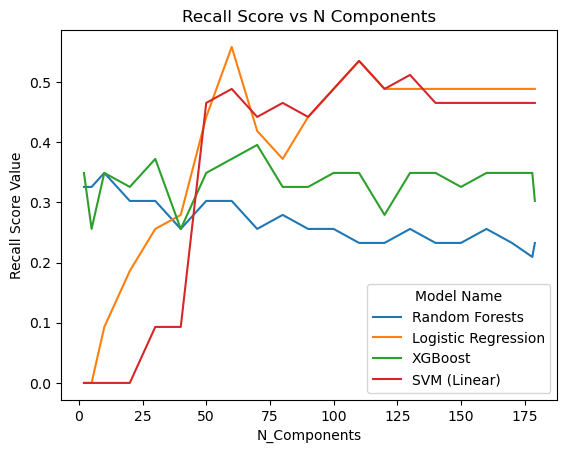

In [198]:
sns.lineplot(x = s1, y =s2, hue = s3, data = df_pca_results)

plt.title("Recall Score vs N Components")
plt.xlabel("N_Components")
plt.ylabel("Recall Score Value")
plt.show()

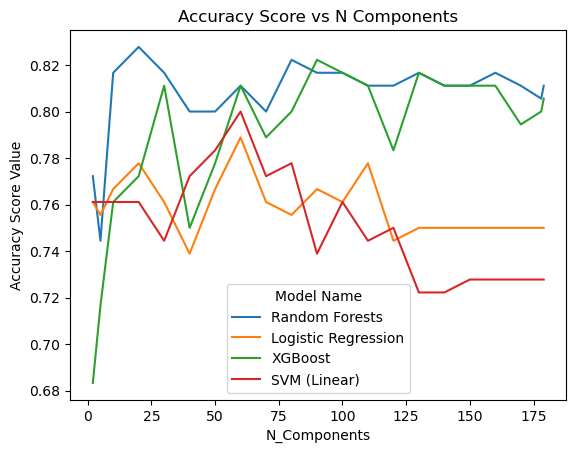

In [199]:
sns.lineplot(x = s1, y =s4, hue = s3, data = df_pca_results)

plt.title("Accuracy Score vs N Components")
plt.xlabel("N_Components")
plt.ylabel("Accuracy Score Value")
plt.show()

In [222]:
j1 = [2, 2, 2, 2,
      10, 10, 10 ,10,
      50, 50, 50, 50,
      100, 100, 100, 100,
      150, 150, 150, 150,
      170, 170, 170, 170,
      178, 178, 178, 178]

j2 = [str1, str2, str3, str4,
      str1, str2, str3, str4,
      str1, str2, str3, str4,
      str1, str2, str3, str4,
      str1, str2, str3, str4,
      str1, str2, str3, str4,
      str1, str2, str3, str4]

j3 = [rft_t1, lr_t1, xg_t1, sv_t1,
      rft_t2, lr_t2, xg_t2, sv_t2,
      rft_t3, lr_t3, xg_t3, sv_t3,
      rft_t4, lr_t4, xg_t4, sv_t4,
      rft_t5, lr_t5, xg_t5, sv_t5,
      rft_t6, lr_t6, xg_t6, sv_t6,
      rft_t7, lr_t7, xg_t7, sv_t7]

j4 = [rft_p1, lr_p1, xg_p1, sv_p1,
      rft_p2, lr_p2, xg_p2, sv_p2,
      rft_p3, lr_p3, xg_p3, sv_p3,
      rft_p4, lr_p4, xg_p4, sv_p4,
      rft_p5, lr_p5, xg_p5, sv_p5,
      rft_p6, lr_p6, xg_p6, sv_p6,
      rft_p7, lr_p7, xg_p7, sv_p7]

In [221]:
#time it lists

rft_t1 = 0.5037617683410645
rft_t2 = 0.32659220695495605
rft_t3 = 0.44625377655029297
rft_t4 = 1.0645263195037842
rft_t5 = 0.5662188529968262
rft_t6 = 0.5979056358337402
rft_t7 = 0.606342077255249


rft_p1 = 0.029501676559448242
rft_p2 = 0.0071277618408203125
rft_p3 = 0.007973909378051758
rft_p4 = 0.01683354377746582
rft_p5 = 0.007974386215209961
rft_p6 = 0.0069768428802490234
rft_p7 = 0.007973909378051758

lr_t1 =  0.004987478256225586
lr_t2 = 0.002993345260620117
lr_t3 = 0.0059795379638671875
lr_t4 = 0.014972209930419922
lr_t5 = 0.011869192123413086
lr_t6 = 0.010968446731567383
lr_t7 = 0.012340307235717773


lr_p1 = 0
lr_p2 = 0
lr_p3 = 0
lr_p4 = 0
lr_p5 = 0
lr_p6 = 0
lr_p7 = 0

xg_t1 = 0.23244810104370117
xg_t2 = 0.05750632286071777
xg_t3 = 0.1561131477355957
xg_t4 = 0.31123948097229004
xg_t5 = 0.39331769943237305
xg_t6 = 0.4457859992980957
xg_t7 = 0.5031023025512695


xg_p1 = 0.010964155197143555
xg_p2 = 0.0009968280792236328
xg_p3 = 0.0009951591491699219
xg_p4 = 0.0021796226501464844
xg_p5 = 0.001068115234375
xg_p6 = 0.0019958019256591797
xg_p7 = 0.0049211978912353516

sv_t1 = 0.011118888854980469
sv_t2 = 0.01993393898010254
sv_t3 = 0.16857433319091797
sv_t4 = 0.062444448471069336
sv_t5 = 0.06486153602600098
sv_t6 = 0.05842709541320801
sv_t7 = 0.0644378662109375


sv_p1 = 0.0019927024841308594
sv_p2 = 0.0009963512420654297
sv_p3 =  0.002082347869873047
sv_p4 = 0.0014960765838623047
sv_p5 = 0.0024263858795166016
sv_p6 = 0.0029909610748291016
sv_p7 = 0.001992464065551758


In [223]:
dic31 = {'Model Name': j2,
      'N Components': j1,
      'Training Time:': j3,
      'Prediction Time:': j4}

df_time = pd.DataFrame(dic31)

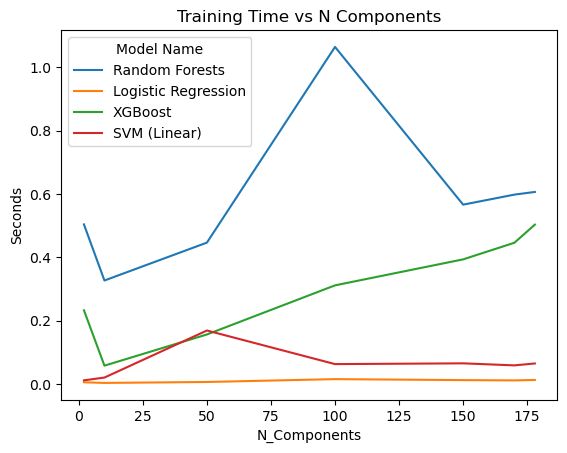

In [226]:
s31 = 'N Components'
s32 = 'Training Time:'
s33 = 'Prediction Time:'
s34 = 'Model Name'
sns.lineplot(x = s31, y =s32, hue = s34, data = df_time)

plt.title("Training Time vs N Components")
plt.xlabel("N_Components")
plt.ylabel("Seconds")
plt.show()

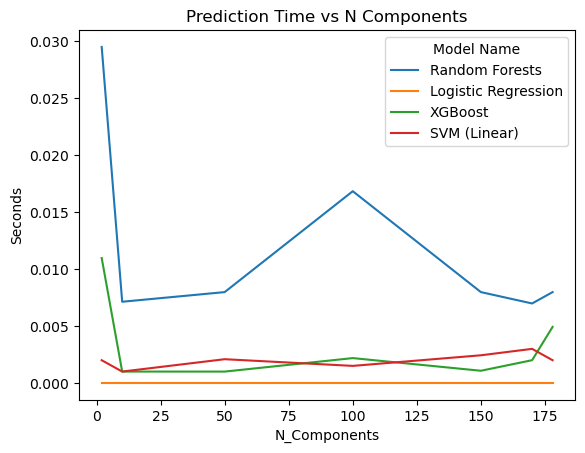

In [227]:
sns.lineplot(x = s31, y =s33, hue = s34, data = df_time)

plt.title("Prediction Time vs N Components")
plt.xlabel("N_Components")
plt.ylabel("Seconds")
plt.show()

In [151]:
# Introduce a random generator with uniform distribution
X_norm['random_uniform'] = np.random.default_rng().uniform(low=0.0, high=1.0, size=len(X_norm))
X_norm['random_uniform1'] = np.random.default_rng().uniform(low=0.0, high=1.0, size=len(X_norm))
X_norm['random_uniform2'] = np.random.default_rng().uniform(low=0.0, high=1.0, size=len(X_norm))
X_norm['random_uniform3'] = np.random.default_rng().uniform(low=0.0, high=1.0, size=len(X_norm))
X_norm['random_uniform4'] = np.random.default_rng().uniform(low=0.0, high=1.0, size=len(X_norm))
                                                        
                                                            


In [152]:
X_train_ran, X_test_ran, y_train_ran, y_test_ran = train_test_split(X_norm, y,  test_size = 0.3, random_state = 42)

In [153]:
#RF PCA
print("RANDOM FORESTS")
rf_baseline.fit(X_train_ran, y_train_ran)
y_pred = rf_baseline.predict(X_test_ran)
#print("Confusion matrix\n", confusion_matrix(y_test_pca, y_pred))
print("Accuracy", accuracy_score(y_test_ran, y_pred))
print("Recall", recall_score(y_test_ran, y_pred))


#LOGISTIC REGRESSION PCA
print("\n\n")
print("LOGISTIC REGRESSION")

logreg.fit(X_train_ran, y_train_ran)
y_pred = logreg.predict(X_test_ran)

print("accuracy: ", accuracy_score(y_test_ran, y_pred))
print("recall:", recall_score(y_test_ran, y_pred))


#XGBOOST PCA

# Train the model
model.fit(X_train_ran, y_train_ran)

# Make predictions
y_pred = model.predict(X_test_ran)

# Evaluate the model
accuracy = accuracy_score(y_test_ran, y_pred)
recall = recall_score(y_test_ran, y_pred)
print("\n\n")
print("XGBOOST")
print("Accuracy:", accuracy)
print("Recall:", recall)
#print("Confusion matrix:")
#print(confusion_matrix(y_test_pca, y_pred))

#LINEAR SVM PCA
print('\n\n')
print("SVM PCA")
# Create SVM classifier with specified kernel
clf = svm.SVC(kernel='linear')
    
# Train the classifier
clf.fit(X_train_ran, y_train)

y_pred = clf.predict(X_test_ran)
# Evaluate the classifier
accuracy = clf.score(X_test_ran, y_test_ran)
print('Accuracy:', accuracy_score(y_test, y_pred))
print('Recall:', recall_score(y_test, y_pred))
print("\n")

RANDOM FORESTS
Accuracy 0.8333333333333334
Recall 0.3953488372093023



LOGISTIC REGRESSION
accuracy:  0.7722222222222223
recall: 0.23255813953488372



XGBOOST
Accuracy: 0.7944444444444444
Recall: 0.46511627906976744



SVM PCA
Accuracy: 0.7722222222222223
Recall: 0.32558139534883723




In [156]:
#RANDOM VARIABLE 1
# RANDOM FORESTS
rf_ran_acc1 = 0.8277777777777777
rf_ran_rec1 = 0.4186046511627907
# LOGISTIC REGRESSION
lr_ran_acc1 = 0.7611111111111111
lr_ran_rec1 = 0.18604651162790697
# XGBOOST
xgb_ran_acc1 = 0.8111111111111111
xgb_ran_rec1 = 0.4883720930232558
# SVM PCA
svm_ran_acc1 = 0.7722222222222223
svm_ran_rec1 = 0.27906976744186046
#RANDOM VARIABLE 2
# RANDOM FORESTS
rf_ran_acc2 = 0.8222222222222222
rf_ran_rec2 = 0.32558139534883723
# LOGISTIC REGRESSION
lr_ran_acc2 =  0.7722222222222223
lr_ran_rec2 = 0.2558139534883721
# XGBOOST
xgb_ran_acc2 = 0.8166666666666667
xgb_ran_rec2 = 0.5348837209302325
# SVM PCA
svm_ran_acc2 = 0.7833333333333333
svm_ran_rec2 = 0.32558139534883723
#RANDOM VARIABLE 3
# RANDOM FORESTS
rf_ran_acc3 = 0.8055555555555556
rf_ran_rec3 = 0.27906976744186046
# LOGISTIC REGRESSION
lr_ran_acc3 =  0.7611111111111111
lr_ran_rec3 = 0.18604651162790697
# XGBOOST
xgb_ran_acc3 = 0.8055555555555556
xgb_ran_rec3 = 0.4883720930232558
# SVM PCA
svm_ran_acc3 = 0.7722222222222223
svm_ran_rec3 = 0.27906976744186046
#Random VARIABLE 
# RANDOM FORESTS
rf_ran_acc4= 0.8444444444444444
rf_ran_rec4 = 0.3953488372093023
# LOGISTIC REGRESSION
lr_ran_acc4 =  0.7777777777777778
lr_ran_rec4 = 0.27906976744186046
# XGBOOST
xgb_ran_acc4 = 0.8277777777777777
xgb_ran_rec4 = 0.5116279069767442
# SVM PCA
svm_ran_acc4 = 0.7777777777777778
svm_ran_rec4 = 0.32558139534883723
#RANDOM VARIABLE 5
# RANDOM FORESTS
rf_ran_acc5 = 0.8333333333333334
rf_ran_rec5 = 0.3953488372093023
# LOGISTIC REGRESSION
lr_ran_acc5 = 0.7722222222222223
lr_ran_rec5 = 0.23255813953488372
# XGBOOST
xgb_ran_acc5 = 0.7944444444444444
xgb_ran_rec5 = 0.46511627906976744
# SVM PCA
svm_ran_acc5 = 0.7722222222222223
svm_ran_rec5 = 0.32558139534883723

In [157]:
l5 = [1, 1, 1, 1,
    2, 2, 2, 2,
    3, 3, 3, 3,
    4, 4, 4, 4,
    5, 5, 5, 5]

l6 = [str1, str2, str3, str4,
    str1, str2, str3, str4,
    str1, str2, str3, str4,
    str1, str2, str3, str4,
    str1, str2, str3, str4]

l7 = [rf_ran_acc1, lr_ran_acc1, xgb_ran_acc1, svm_ran_acc1,
      rf_ran_acc2, lr_ran_acc2, xgb_ran_acc2, svm_ran_acc2,
      rf_ran_acc3, lr_ran_acc3, xgb_ran_acc3, svm_ran_acc3,
      rf_ran_acc4, lr_ran_acc4, xgb_ran_acc4, svm_ran_acc4,
      rf_ran_acc5, lr_ran_acc5, xgb_ran_acc5, svm_ran_acc5]

l8 = [rf_ran_rec1, lr_ran_rec1, xgb_ran_rec1, svm_ran_rec1,
      rf_ran_rec2, lr_ran_rec2, xgb_ran_rec2, svm_ran_rec2,
      rf_ran_rec3, lr_ran_rec3, xgb_ran_rec3, svm_ran_rec3,
      rf_ran_rec4, lr_ran_rec4, xgb_ran_rec4, svm_ran_rec4,
      rf_ran_rec5, lr_ran_rec5, xgb_ran_rec5, svm_ran_rec5]

In [159]:
dic2 = {'Model Name': l6,
      'Number of Random Variables Added': l5,
      'Accuracy Score': l7,
      'Recall Score': l8}

df_randomvar = pd.DataFrame(dic2)

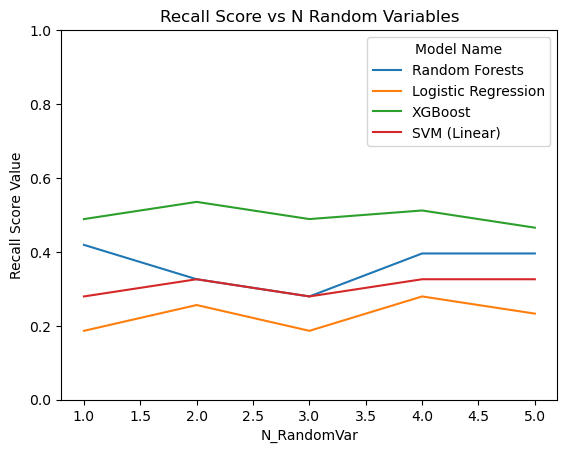

In [166]:
s5 = 'Model Name'
s6 = 'Number of Random Variables Added'
s7 = 'Accuracy Score'
s8 = 'Recall Score'

sns.lineplot(x = s6, y =s8, hue = s5, data = df_randomvar)

plt.ylim(bottom = 0, top = 1)
plt.title("Recall Score vs N Random Variables")
plt.xlabel("N_RandomVar")
plt.ylabel("Recall Score Value")
plt.show()

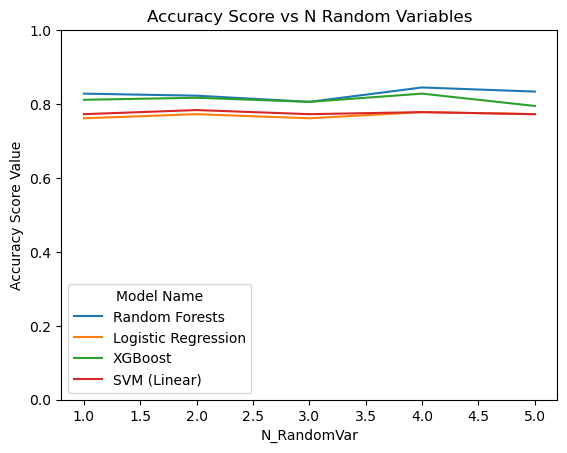

In [168]:
s5 = 'Model Name'
s6 = 'Number of Random Variables Added'
s7 = 'Accuracy Score'
s8 = 'Recall Score'

sns.lineplot(x = s6, y =s7, hue = s5, data = df_randomvar)

plt.ylim(bottom = 0, top = 1)
plt.title("Accuracy Score vs N Random Variables")
plt.xlabel("N_RandomVar")
plt.ylabel("Accuracy Score Value")
plt.show()

In [170]:
import shap

In [177]:
X_train_top10, X_test_top10, y_train_top10, y_test_top10 = train_test_split(X_top10, y, test_size = 0.3, random_state = 42)

(417, 10)

In [179]:
#Use poly dataset for random forest

rf_model = RandomForestClassifier()
rf_model.fit(X_train_top10, y_train_top10)

RandomForestClassifier()

<Figure size 640x480 with 0 Axes>

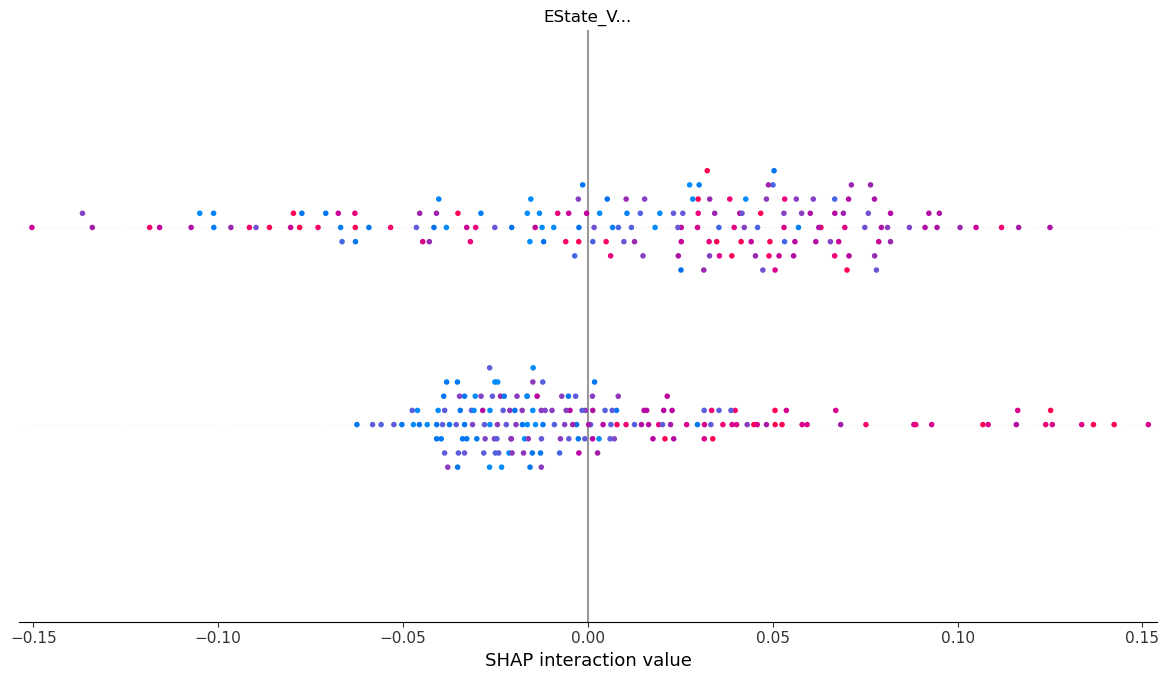

In [195]:

explainer = shap.TreeExplainer(rf_model)
shap_values = explainer.shap_values(X_test_top10)
shap.summary_plot(shap_values, X_test_top10, feature_names = X_test_top10.columns)


In [196]:
X_top10

,PEOE_VSA7,EState_VSA10,Chi3v,ExactMolWt,SlogP_VSA5,Chi0n,Chi1,NumValenceElectrons,NHOHCount,MolLogP
0,18.199,9.185,4.719,422.162,5.563,16.781,14.901,158,4,2.443
1,24.443,10.002,3.735,236.062,17.843,8.752,7.592,84,3,2.732
2,0.000,9.901,0.603,117.079,0.000,5.471,3.417,48,0,-1.557
3,43.686,19.398,4.998,411.185,38.425,16.995,14.274,158,3,4.628
4,31.189,17.966,2.171,270.062,12.487,9.746,8.752,100,2,2.999
...,...,...,...,...,...,...,...,...,...,...
115,26.335,33.874,8.132,516.155,32.377,19.925,16.973,192,2,-1.575
116,30.686,4.795,2.350,211.075,11.257,8.689,7.720,78,1,1.617
117,67.289,5.107,5.620,315.166,35.769,13.294,10.775,118,1,4.266
118,33.258,19.703,4.478,418.174,39.176,17.683,14.167,162,1,2.971
